In [1]:
import os, psutil
import importlib

import einops
import numpy as np
import ssm
import matplotlib.pyplot as plt
from tqdm import tqdm

/opt/conda/envs/slds/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.set_printoptions(precision=3)
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
total_memory = psutil.virtual_memory().total
available_memory = psutil.virtual_memory().available
print(f"The available RAM memory is {available_memory / (1024**3):.2f} GB out of {total_memory / (1024**3):.2f} GB")

The available RAM memory is 55.15 GB out of 125.68 GB


In [9]:
import os, psutil, sys
import importlib

import einops
import numpy as np
import ssm
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn

from pathlib import Path
# parent_directory = Path(__file__).resolve().parent
parent_directory = Path(os.getcwd()).resolve().parent
sys.path.append(str(parent_directory))

# Generate data

In [279]:
import ssm

num_states = 1
obs_dim = 2
time_bins = 10000

true_hmm = ssm.HMM(
    num_states, obs_dim, 
    observations="autoregressive",
    # observations="gaussian",
    transitions="inputdriven"
)

true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [280]:
# true_hmm.observations._As, true_hmm.observations.bs

In [282]:
# vars(true_hmm.observations)

In [283]:
x = torch.tensor(obs, dtype=torch.float32).to(device)

# Whitening of the data

In [694]:
import autoregression
importlib.reload(autoregression)

config = autoregression.ARConfig(
    n_states=num_states,
    n_features=obs_dim,
    ar_order=1,
)
device = 'cpu'

In [695]:
ar = autoregression.Autoregression(config).to(device)

### set whitening_filters to the AR and mu coefs

In [701]:
torch.manual_seed(0)
x = torch.tensor(obs, dtype=torch.float32).to(device)
x_mean = einops.rearrange(x, 't f -> f t')
x_cov = torch.randn((x_.shape[0], x_.shape[0], x_.shape[-1]), dtype=torch.float32).to(device)
x_cov = torch.einsum('cCt, sCt -> cst', x_cov, x_cov)
x_cov[:] = 0

In [703]:
ar.An[:,1] = torch.tensor(true_hmm.observations._As[0], dtype=torch.float32, device=device)
ar.An[:,-1] = torch.diag(torch.tensor(true_hmm.observations.bs[0], dtype=torch.float32, device=device))
ar._update_filters()

In [704]:
%%time
y = ar.whitening_filters[0](ar.pad(x_mean)).detach().cpu().numpy()

CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 5.95 ms


In [705]:
print(np.mean(y, axis=-1))

[-0.004  0.003]


In [706]:
gamma = torch.ones((n_samples, config_ar.n_states), device=x_mean.device) / config_ar.n_states

In [707]:
%%time
ar._estimate_autoregression(x_mean, x_cov, gamma)

CPU times: user 2.31 ms, sys: 154 µs, total: 2.46 ms
Wall time: 1.86 ms


tensor([[[[ 0.0927,  0.7912],
          [-0.7922,  0.0970]],

         [[-1.0855,  0.0000],
          [ 0.0000, -0.2664]]]])

In [708]:
%%time
ar._estimate_covariance(x_mean, x_cov, gamma)

CPU times: user 8.26 ms, sys: 2.35 ms, total: 10.6 ms
Wall time: 3.65 ms


tensor([[[ 2.0094, -1.3340],
         [-1.3340,  0.9334]]])

In [709]:
# %%time
# ar._estimate_covariance_slow(x_mean, x_cov, gamma)

In [710]:
ar.fit(x_mean, x_cov)

In [711]:
ar.reset()

In [712]:
ar.fit(x_mean, x_cov)

In [713]:
ar.Sigma

tensor([[[ 2.0093, -1.3340],
         [-1.3340,  0.9333]]])

In [714]:
%%time
log_prob_ar = ar.emission_log_prob(x_mean)

CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 3.04 ms


In [715]:
%%time
log_prob_ar = ar.emission_log_prob_pytorch(x_mean)

CPU times: user 18.9 ms, sys: 0 ns, total: 18.9 ms
Wall time: 3.58 ms


In [638]:
def emission_log_prob_pytorch(x_mean, ar):

    log_prob = torch.zeros(ar.config.n_states, x_mean.shape[-1], device=x_mean.device)
    es = ar._signal_whitening(x_mean)
    es = einops.rearrange(es, 'k c t -> k t c')
    
    mean = torch.zeros(ar.config.n_features, device=x_mean.device)
    for k in range(ar.config.n_states):
        covariance_matrix_k = ar.Sigma[k]
        distribution = MultivariateNormal(mean, covariance_matrix)
        log_prob[k] = distribution.log_prob(es[k])
    
    return log_prob

In [639]:
%%time
log_prob_pytorch = emission_log_prob_pytorch(x_mean, ar)

CPU times: user 0 ns, sys: 2.78 ms, total: 2.78 ms
Wall time: 2.12 ms


In [621]:
ar.Sigma.shape

torch.Size([1, 2, 2])

# HMM

In [1275]:
import autoregression
importlib.reload(autoregression)

import hidden_markov_model
importlib.reload(hidden_markov_model)

<module 'hidden_markov_model' from '/home/user/common/amvosk/Projects/Speech Mapping Advanced/hidden_markov_model.py'>

In [1421]:
class ARHMM(nn.Module):
    def __init__(
        self,
        config_ar,
        config_hmm,
        random_seed,
    ):
        super(self.__class__,self).__init__()
        self.config_hmm = config_hmm
        self.config_ar = config_ar

        self.hmm = hidden_markov_model.HMM(self.config_hmm, random_seed)
        self.ar = autoregression.Autoregression(self.config_ar)
        
    def forward(self, x):
        return None
        
    def fit(self, x_mean, x_cov, n_iterations=50, mask=None):
        log_probs = []
        for iteration in tqdm(range(n_iterations)):
            
            emissions = self.ar.emission_log_prob(x_mean)
            log_prob, gamma = self.hmm.fit(emissions)
            self.ar.fit(x_mean, x_cov, gamma)
            log_probs.append(log_prob.detach().cpu().numpy().item())
        return log_probs
            
    def predict(self, x_mean):
        emissions = self.ar.emission_log_prob(x_mean)
        path = self.hmm.predict(emissions)
        return path

# Generate some GaussHMM data

In [1293]:
import ssm

num_states = 3
obs_dim = 2
time_bins = 1000
observations = "gaussian"
# observations = "autoregressive"

true_hmm = ssm.HMM(
    num_states, obs_dim, 
    observations=observations,
    transitions="inputdriven"
)

true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [1294]:
config_ar = autoregression.ARConfig(
    n_states=num_states,
    n_features=obs_dim,
    ar_order= 0 if observations == "gaussian" else 1,
    covariance_type='full'
)

# device = 'cuda'
device = 'cpu'

config_hmm = hidden_markov_model.HMMConfig(
    n_states=num_states,
    init_state_type='uniform',
    transition_matrix_type='random',
    transition_type='full',
    diagonal_coef=0,
    first_coef=0,
    ergodicity_coef=0,
    temperature=1,
)

random_seed = 42

## From library

In [1295]:
N_iters = 50

## testing the constrained transitions class
hmm_ssm = ssm.HMM(num_states, obs_dim, observations=observations)

hmm_lls = hmm_ssm.fit(obs, method="em", num_iters=N_iters)#, init_method="kmeans")

LP: -2253.8: 100%|██████████| 50/50 [00:00<00:00, 235.03it/s]


## Mine

In [1296]:
torch.manual_seed(0)
x = torch.tensor(obs, dtype=torch.float32).to(device)
x_mean = einops.rearrange(x, 't f -> f t')
x_cov = torch.randn((x_.shape[0], x_.shape[0], x_.shape[-1]), dtype=torch.float32).to(device)
x_cov = torch.einsum('cCt, sCt -> cst', x_cov, x_cov)
x_cov[:] = 0

In [1297]:
arhmm = ARHMM(config_ar, config_hmm, random_seed).to(device)
N_iters = 50

log_prob = arhmm.fit(x_mean, x_cov, n_iterations=N_iters)
log_prob[-1]

100%|██████████| 50/50 [00:07<00:00,  6.67it/s]


-2253.75634765625

In [1298]:
# plt.plot(log_prob)

In [1299]:
mu, sigma = arhmm.ar._get_mean().cpu().numpy(), arhmm.ar._get_cov().cpu().numpy()

In [1300]:
mu_true = true_hmm.observations.mus
mu_learned = hmm_ssm.observations.mus
mu_mine = arhmm.ar._get_mean().cpu().numpy()

In [1301]:
sigma_true = np.einsum('kcC, ksC -> kcs', true_hmm.observations._sqrt_Sigmas, true_hmm.observations._sqrt_Sigmas)
sigma_learned = np.einsum('kcC, ksC -> kcs', hmm_ssm.observations._sqrt_Sigmas, hmm_ssm.observations._sqrt_Sigmas)
sigma_mine = arhmm.ar._get_cov().cpu().numpy()

In [1302]:
def plot_ar_matrix(matrices):
    n_matrices = matrices.shape[0]
    fig, ax = plt.subplots(1, n_matrices, figsize=(15, 3))

    for i in range(n_matrices):
        matrix = matrices[i]
        vmax = np.max(np.abs(matrix))
        vmin = -vmax
        cmap = plt.get_cmap("coolwarm")
        # Plot the covariance matrix using imshow
        im = ax[i].imshow(matrix, cmap=cmap, vmin=vmin, vmax=vmax)

        cax = fig.add_axes([ax[i].get_position().x1 + 0.01, ax[i].get_position().y0, 0.02, ax[i].get_position().height])
        cbar = fig.colorbar(im, cax=cax)
        
        
        num_variables = matrix.shape[0]
        tick_positions = np.arange(num_variables)
        ax[i].set_xticks(tick_positions)
        ax[i].set_yticks(tick_positions)
        ax[i].set_xticklabels(tick_positions)
        ax[i].set_yticklabels(tick_positions)

        ax[i].set_title(f'ar state {i}')
    plt.show()

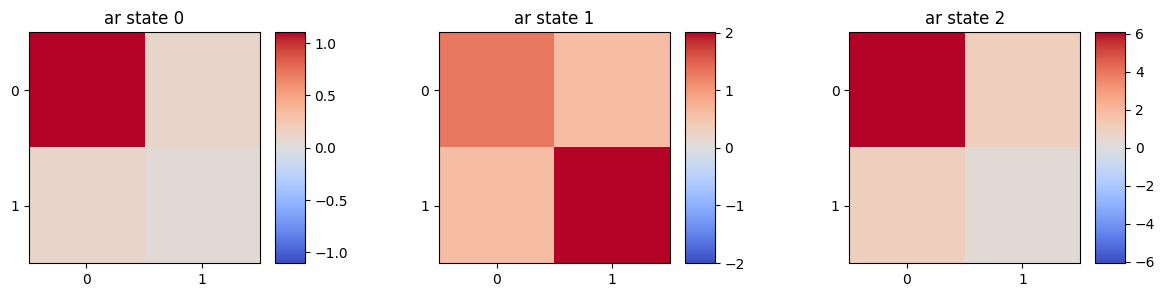

In [1303]:
plot_ar_matrix(sigma_true)

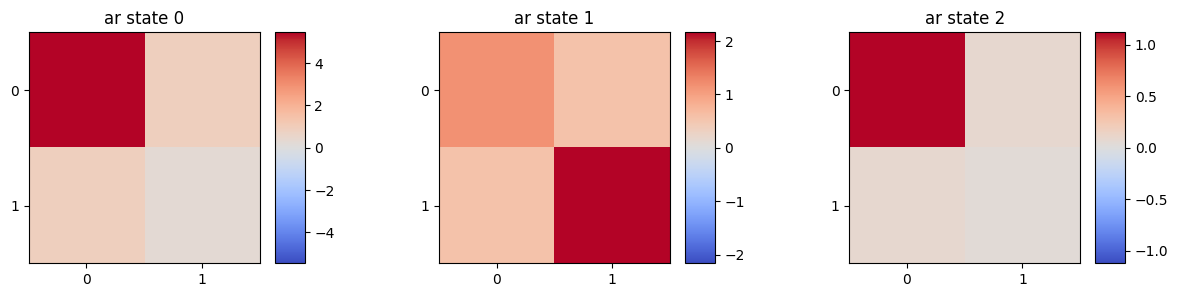

In [1304]:
plot_ar_matrix(sigma_learned)

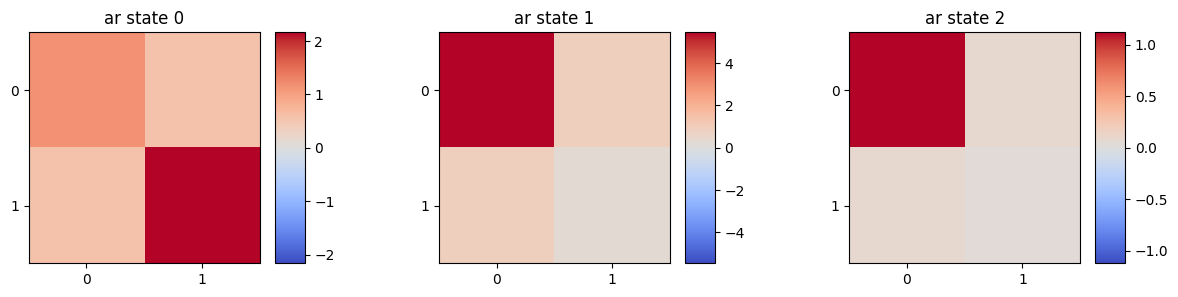

In [1305]:
plot_ar_matrix(sigma_mine)

# Generate some AR-HMM data

In [1511]:
import autoregression
importlib.reload(autoregression)

import hidden_markov_model
importlib.reload(hidden_markov_model)

<module 'hidden_markov_model' from '/home/user/common/amvosk/Projects/Speech Mapping Advanced/hidden_markov_model.py'>

In [1512]:
import ssm

num_states = 3
obs_dim = 2
time_bins = 1000
observations = "autoregressive"

true_hmm = ssm.HMM(
    num_states, obs_dim, 
    observations=observations,
    transitions="inputdriven"
)

true_states, obs = true_hmm.sample(time_bins)
true_ll = true_hmm.log_probability(obs)

In [1540]:
config_ar = autoregression.ARConfig(
    n_states=num_states,
    n_features=obs_dim,
    ar_order= 0 if observations == "gaussian" else 1,
    covariance_type='full' # 'full', 'diagonal', 'spherical', 'common', 'identity'
)

# device = 'cuda'
device = 'cpu'

config_hmm = hidden_markov_model.HMMConfig(
    n_states=num_states,
    init_state_type='uniform',
    transition_matrix_type='random',
    transition_type='full',
    diagonal_coef=0,
    first_coef=0,
    ergodicity_coef=0,
    temperature=1,
)

random_seed = 42

In [1541]:
N_iters = 50

## testing the constrained transitions class
hmm_ssm = ssm.HMM(num_states, obs_dim, observations=observations)

hmm_lls = hmm_ssm.fit(obs, method="em", num_iters=N_iters)#, init_method="kmeans")

LP: -2438.1: 100%|██████████| 50/50 [00:00<00:00, 239.11it/s]


In [1542]:
torch.manual_seed(0)
x = torch.tensor(obs, dtype=torch.float32).to(device)
x_mean = einops.rearrange(x, 't f -> f t')
x_cov = torch.randn((x_mean.shape[0], x_mean.shape[0], x_mean.shape[-1]), dtype=torch.float32).to(device)
x_cov = torch.einsum('cCt, sCt -> cst', x_cov, x_cov)
x_cov[:] = 0

In [1543]:
x_mean.shape

torch.Size([2, 1000])

In [1544]:
arhmm = ARHMM(config_ar, config_hmm, random_seed).to(device)
N_iters = 50

log_prob = arhmm.fit(x_mean, x_cov, n_iterations=N_iters)
log_prob[-1]

100%|██████████| 50/50 [00:03<00:00, 13.46it/s]


-2443.96533203125

In [1545]:
%%time
emissions = arhmm.ar.emission_log_prob(x_mean)

CPU times: user 2.53 ms, sys: 806 µs, total: 3.33 ms
Wall time: 1.53 ms


In [1546]:
%%time
log_prob, gamma = arhmm.hmm.fit(emissions)

CPU times: user 99.6 ms, sys: 2.38 ms, total: 102 ms
Wall time: 74.6 ms


In [1547]:
%%time
arhmm.ar.fit(x_mean, x_cov, gamma)

CPU times: user 30.1 ms, sys: 0 ns, total: 30.1 ms
Wall time: 3.42 ms


In [1548]:
arhmm.ar.Sigma

tensor([[[ 0.3778,  0.0351],
         [ 0.0351,  0.0053]],

        [[ 5.1890, -1.1483],
         [-1.1483,  4.7190]],

        [[ 1.8048, -1.7670],
         [-1.7670,  1.9583]]])